# Exponential Mechanism
This notebook contains the code used to reproduce the mechanism of (Yue et al., 2021). This code was used in Section 7 of the paper to compare it with our fixed mechanism

In [2]:
import pickle
from os.path import join
import numpy as np
from collections import Counter
from scipy.special import softmax
from concurrent.futures import ProcessPoolExecutor
from pathlib import Path
import sys

# Add the main directory to sys.path to be able to import config
sys.path.append(str(Path.cwd().parent))
from config import ROOT_DIR
from utils.tools import rank_neighbors, compute_distances

# PARAMS
number_of_words = 5000
# END PARAMS

distance_metric = "euclidean"
distances_dtype = np.float32  # Precision of the distances
# !!! float32 (at least) needed to avoid overflow when computing probabilities

fasttext_data_folderpath = ROOT_DIR

Load Fasttext

In [3]:
with open(join(fasttext_data_folderpath, "wiki.en.pkl"), "rb") as f:
    fasttext = pickle.load(f)

vocab_embs = np.array(list(fasttext.values()))
vocab_size = vocab_embs.shape[0]
hidden_size = vocab_embs.shape[1]
del fasttext  # Save RAM

CPU times: user 1min 21s, sys: 18.5 s, total: 1min 40s
Wall time: 1min 40s


Select *number_of_words* random words and rank their neighbors according to their distance with the word in the embedding space.

In [ ]:
words_ids = np.random.choice(vocab_size, size=number_of_words, replace=False)
words_embs = vocab_embs[words_ids]

# Get the distances between the selected words and the entire vocabulary
distances = compute_distances(
    words_embs, vocab_embs, distance_metric, dtype=distances_dtype
)

# Also rank the entire vocabulary
words_neighbors_ranked = rank_neighbors(words_embs, vocab_embs, distance_metric)

CPU times: user 45.8 s, sys: 17.9 s, total: 1min 3s
Wall time: 1min 5s


Add noise to the embeddings of the words following the $d_x$-privacy mechanism and count which neighbor was chosen, represented by its rank in the neighbor list of the initial word.

In [5]:
epsilons = np.arange(0.5, 10.5, 0.5)
neighbor_counted_occurences = {}

# Process epsilons in parallel
n_workers = 1


def process_epsilon(epsilon):
    # Compute the probabilities
    probabilities = softmax(-1 / 2 * epsilon * distances, axis=-1)

    # Sample one replacement for each word
    noisy_word_ids = [
        np.random.choice(vocab_size, p=probabilities[i]) for i in range(number_of_words)
    ]

    # for all words_ids, get the rank k of noisy_word_ids[i] and increase a counter at index k
    noisy_word_ids_ranks = words_neighbors_ranked[
        np.arange(number_of_words), noisy_word_ids
    ]  # This line, for all the elements i in the first dimension of words_neighbors_ranked, gets the particular value pointed by the index which is stored at noisy_word_ids[i]

    noisy_word_ids_ranks_counted = Counter(noisy_word_ids_ranks)
    return [noisy_word_ids_ranks_counted[k] for k in range(vocab_size)]


with ProcessPoolExecutor(max_workers=n_workers) as executor:
    results = list(executor.map(process_epsilon, epsilons))

neighbor_counted_occurences = dict(zip(epsilons, results))

CPU times: user 3.29 s, sys: 9.45 s, total: 12.7 s
Wall time: 1h 13min 33s


Results are stored in *neighbor_counted_occurences*, which is a dictionary where the keys are integers representing the value of epsilon. The dictionary associates each epsilon with a list, where list[i] contains the number of times the i-th neighbor was chosen as the replacement of a word. 

Plot

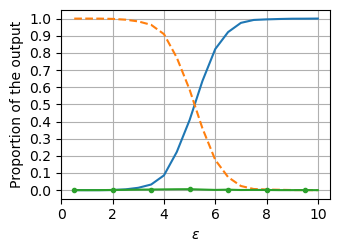

In [6]:
import matplotlib.pyplot as plt
close_neighbors_max_rank = 100 # The maximum rank (including) of what is considered a "close" neighbor 

initial_word_frequency = np.array([neighbor_counted_occurences[i][0] for i in epsilons])
close_neighbors_frequency = np.array([sum(neighbor_counted_occurences[i][1:close_neighbors_max_rank+1]) for i in epsilons])
distant_neighbors_frequency = np.array([sum(neighbor_counted_occurences[i][close_neighbors_max_rank+1:]) for i in epsilons])

fig, ax = plt.subplots(figsize=(3.5, 2.62))

ax.plot(epsilons, initial_word_frequency/number_of_words, label="Original value", linewidth=1.5, markersize=5)
ax.plot(epsilons, distant_neighbors_frequency/number_of_words, label="Distant neighbors", linewidth=1.5,linestyle='dashed')
ax.plot(epsilons, close_neighbors_frequency/number_of_words, label="Close neighbors", linewidth=1.5, marker=".", markevery=3)

ax.set_xlabel("$\epsilon$")
ax.set_ylabel("Proportion of the output")
ax.set_yticks(np.arange(0, 1.1, 0.1))

ax.set_xlim(0)
#ax.legend(framealpha=0.4, loc="right")
ax.grid()
fig.tight_layout()
fig.show()